In [1]:
import os

import numpy as np
import scipy.optimize as sco
import scipy.special as scp
import scipy.integrate as sci

import matplotlib.pyplot as plt

## Declare functions for root-finding

In [2]:
# Functions for integrating (cos x)^{+/-0.5}, (sin x)^{+/-0.5}

def integ_sqrt_cos(x):
    """ Returns the integral of sqrt(cos) on [0, x] using incomplete beta functions
    \int_0^x \sqrt{cos t} dt = 0.5 * \int_0^{(sinx)^2} u^(-0.5)*(1-u)^(-0.25)du"""
    a, b = 0.5, 0.75
    beta_ratio = scp.betainc(a, b, np.sin(x)**2)
    return 0.5 * beta_ratio * scp.beta(a, b)
    

def integ_sqrt_sin(x):
    """ Return the integral of sqrt(sin) on [0, x] using incomplete beta function 
    \int_0^x \sqrt{sin t} dt = 0.5 * beta(0.5, 0.75) - 0.5 * \int_0^{(cos x)^2} u^(-0.5)*(1-u)^(-0.25)du"""
    a, b = 0.5, 0.75
    beta_ratio = 1 - scp.betainc(a, b, np.cos(x)**2)
    return 0.5 * beta_ratio * scp.beta(a, b)

def integ_inv_sqrt_cos(x):
    """ Returns the integral of 1/sqrt(cos) on [0, x] using incomplete beta functions
    \int_0^x 1/\sqrt{cos t} dt = 0.5 * \int_0^{(sinx)^2} u^(-0.5)*(1-u)^(-0.75)du"""
    a, b = 0.5, 0.25
    beta_ratio = scp.betainc(a, b, np.sin(x)**2)
    return 0.5 * beta_ratio * scp.beta(a, b)

def integ_inv_sqrt_sin(x):
    """ Return the integral of 1/sqrt(sin) on [0, x] using incomplete beta function 
    \int_0^x 1/\sqrt{sin t} dt = 0.5 * beta(0.5, 0.25) - 0.5 * \int_0^{(cos x)^2} u^(-0.5)*(1-u)^(-0.75)du"""
    a, b = 0.5, 0.25
    beta_ratio = 1 - scp.betainc(a, b, np.cos(x)**2)
    return 0.5 * beta_ratio * scp.beta(a, b)


In [ ]:
# Old code

def check_angles_float(alpha_1, alpha_2):
    if alpha_1 < 0.:
        print("Warning: alpha_1 < 0")
        alpha_1 = 0.
    if alpha_1 > np.pi/2.:
        print("Warning: alpha_1 > pi/2")
        alpha_1 = np.pi/2.
    if alpha_2 < 0.:
        print("Warning: alpha_2 < 0")
        alpha_2 = 0.
    if alpha_2 > np.pi/2.:
        print("Warning: alpha_2 > pi/2")
        alpha_2 = np.pi/2.
    if alpha_1 < alpha_2:
        print("Warning: alpha_1 < alpha_2")
        alpha_1, alpha_2 = np.mean(alpha_1, alpha_2), np.mean(alpha_1, alpha_2) 
    return alpha_1, alpha_2

def func_naiv_all(alpha_1, alpha_2, force, W, a, H):
    # Check that arguments are on correct set
    alpha_1, alpha_2 = check_angles_float(alpha_1, alpha_2)
    force = np.max([force, 0.])

    # Compute elliptic functions
    P_a1_a2 = integ_sqrt_sin(alpha_1 - alpha_2) 
    M_a2 = integ_sqrt_cos(alpha_2)

    # Right hand side equations
    eq1 = 2 * np.cos(alpha_1) * np.sqrt(np.sin(alpha_1-alpha_2)) + np.sin(alpha_1) * P_a1_a2
    eq2 = 2 * np.sin(alpha_1) * np.sqrt(np.sin(alpha_1-alpha_2)) - np.cos(alpha_1) * P_a1_a2
    eq3 = np.sqrt(np.cos(alpha_2) / np.sin(alpha_1 - alpha_2)) * M_a2

    prefac = np.sqrt(2 * force)

    return np.array([eq1 - prefac * W, 
                     eq2 - prefac * H, 
                     eq3 - prefac * a])

def jac_naiv_all(alpha_1, alpha_2, force, W, a, H):
    #TODO
    dfact1_d1 = 0.5 * np.cos(alpha_1 - alpha_2) * np.cos(alpha_1) / np.sqrt(np.sin(alpha_1 - alpha_2)) - np.sin(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))
    dfact3_d1 = 0.5 * np.cos(alpha_1 - alpha_2) * np.sin(alpha_1) / np.sqrt(np.sin(alpha_1 - alpha_2)) + np.cos(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))

    dfact1_d2 = - 0.5 * np.cos(alpha_1) * np.cos(alpha_1 - alpha_2) / np.sqrt(np.sin(alpha_1 - alpha_2))
    dfact3_d2 = - 0.5 * np.sin(alpha_1) * np.cos(alpha_1 - alpha_2) / np.sqrt(np.sin(alpha_1 - alpha_2))

    dfact2_d1 = np.cos(alpha_1) * integ_sqrt_sin(alpha_1 - alpha_2) + np.sin(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))
    dfact2_d2 = - np.sin(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))

    dfact4_d1 = np.sin(alpha_1) * integ_sqrt_sin(alpha_1 - alpha_2) - np.cos(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))
    dfact4_d2 = np.cos(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))

    dfact5_d1 = - np.cos(alpha_1 - alpha_2) / np.sin(alpha_1 - alpha_2) * np.sqrt(np.cos(alpha_2) / np.sin(alpha_1 - alpha_2)) * integ_sqrt_cos(alpha_2)

    return 0.

In [112]:
# Code 22/01/2024

def check_angles(alpha1, alpha2):
    # Take max(0, alpha)
    alpha1 = (alpha1 + np.abs(alpha1)) / 2.
    alpha2 = (alpha2 + np.abs(alpha2)) / 2.

    # Take min(pi/2, alpha)
    alpha1 = np.pi/2 - ((np.pi/2. - alpha1) + np.abs(np.pi/2. - alpha1)) / 2.
    alpha2 = np.pi/2 - ((np.pi/2. - alpha2) + np.abs(np.pi/2. - alpha2)) / 2.

    # Take alpha2 = min(alpha2, alpha1)
    alpha2 = alpha1 - ((alpha1 - alpha2) + np.abs(alpha1 - alpha2)) / 2.

    return alpha1, alpha2

def func_all(alpha1, alpha2, force, W, H, a):
    # Check that arguments are on correct set (alpha in [0, pi/2], force>0)
    alpha1, alpha2 = check_angles(alpha1, alpha2)
    force = (force + np.abs(force)) / 2.

    # Compute primitives sqrt(cos), sqrt(sin)
    P_a1_a2 = integ_sqrt_sin(alpha1 - alpha2)
    M_a2 = integ_sqrt_cos(alpha2)

    # Functions to find roots
    eq1 = force * (W * np.cos(alpha1) + H * np.sin(alpha1))**2 - 2 * np.sin(alpha1 - alpha2)
    eq2 = 2 * force * (W * np.sin(alpha1) - H * np.cos(alpha1))**2 - P_a1_a2**2
    eq3 = np.cos(alpha2) * M_a2**2 - 2 * force * a**2 * np.sin(alpha1 - alpha2)

    return np.array([eq1, eq2, eq3])

def jac_all(alpha1, alpha2, force, W, H, a):
    # Check that arguments are on correct set (alpha in [0, pi/2], force>0)
    alpha1, alpha2 = check_angles(alpha1, alpha2)
    force = (force + np.abs(force)) / 2.

    # Compute primitives sqrt(cos), sqrt(sin)
    P_a1_a2 = integ_sqrt_sin(alpha1 - alpha2)
    M_a2 = integ_sqrt_cos(alpha2)

    # Shortcuts
    cos1, sin1 = np.cos(alpha1), np.sin(alpha1)
    cos2, sin2 = np.cos(alpha2), np.sin(alpha2)
    cos12, sin12 = np.cos(alpha1 - alpha2), np.sin(alpha1 - alpha2)

    # Derivatives
    deq1_da1 = 2 * force * (H * cos1 - W * sin1) * (W * cos1 + H * sin1) - 2 * cos12
    deq1_da2 = 2 * cos12
    deq1_df = (W * cos1 + H * sin1)**2

    deq2_da1 = 4 * force * (W * cos1 + H * sin1) * (W * sin1 - H * cos1) - 2 * P_a1_a2 * np.sqrt(sin12)
    deq2_da2 = - 2 * P_a1_a2 * np.sqrt(sin12)
    deq2_df = 2 * (W * sin1 - H * cos1)**2

    deq3_da1 = - 2 * force * a**2 * cos12
    deq3_da2 = - sin2 - M_a2**2 + 2 * cos2 * M_a2 * np.sqrt(cos2) + 2 * force * a**2 * cos12
    deq3_df = - 2 * a**2 * sin12

    return np.array([[deq1_da1, deq1_da2, deq1_df], 
                     [deq2_da1, deq2_da2, deq2_df],
                     [deq3_da1, deq3_da2, deq3_df]])


def s1_s2_from_alpha_f(alpha1, alpha2, force, L):

    s2_s1 = 1. / np.sqrt(2 * force) * integ_inv_sqrt_sin(alpha1 - alpha2)
    L_s2 = 1. / np.sqrt(2 * force * np.sin(alpha1 - alpha2) / np.cos(alpha2)) * integ_inv_sqrt_cos(alpha2)
    print(L_s2)

    s2 = L - L_s2
    s1 = s2 - s2_s1

    return s1, s2

def solve_from_all_param(s1, s2, L, alpha1, alpha2, force, nbPoints=50):
    def func_2(s, y):
        return np.array([y[1], 
                         -force * np.cos(y[0] - alpha1)])
    def func_3(s, y):
        return np.array([y[1], 
                         -force * np.sin(alpha1-alpha2) / np.cos(alpha2) * np.sin(y[0])])
    
    t_eval_1 = np.linspace(0, s1, nbPoints)
    
    t_span_2 = [s1, s2]
    y0_2 = np.array([alpha1, 0])
    t_eval_2 = np.linspace(*t_span_2, nbPoints)

    t_span_3 = [s2, L]
    y0_3 = np.array([alpha2, - np.sqrt(2*force * np.sin(alpha1-alpha2))])
    t_eval_3 = np.linspace(*t_span_3, nbPoints)

    sol_1 = np.full_like(t_eval_1, alpha1)
    sol_2 = sci.solve_ivp(func_2, t_span_2, y0_2, t_eval_2)
    sol_3 = sci.solve_ivp(func_3, t_span_3, y0_3, t_eval_3)

    return (np.concatenate((t_eval_1, sol_2.t, sol_3.t)), 
            np.concatenate((sol_1, sol_2.y, sol_3.y)))



In [59]:
# Code 23/01/2024 -> from notes

HUGE = 1e16

def check_arguments(alpha1, alpha2, force):
    isTooSmall = ((alpha1 < 0) | (alpha2 <0))
    isTooLarge = ((alpha1 > np.pi/2) | (alpha2 > np.pi/2))
    isWrongOrder = (alpha1 < alpha2)

    isForceNeg = (force < 0)
    
    return ~(isTooLarge | isTooSmall | isWrongOrder | isForceNeg)

def func_root_all(alpha1, alpha2, force, W, H, a):
    # Check is arguments correct
    args_correct = check_arguments(alpha1, alpha2, force)

    # Compute primitives sqrt(cos), sqrt(sin)
    P_a1_a2 = integ_sqrt_sin(alpha1 - alpha2)
    M_a2 = integ_sqrt_cos(alpha2)

    # Writes shortcuts
    sin1, cos1 = np.sin(alpha1), np.cos(alpha1)
    sin12 = np.sin(alpha1 - alpha2)
    cos2 = np.cos(alpha2)

    # Compute functions to find roots of
    eq1 = force * (cos1 * W + sin1 * H)**2 - 2 * sin12
    eq2 = np.sqrt(2 * np.abs(force)) * (sin1 * W - cos1 * H) - P_a1_a2
    eq3 = 2 * force * sin12 * a**2 - cos2 * M_a2**2

    equations = np.array([eq1, eq2, eq3])
    equations[:,~args_correct] = HUGE

    return equations

def s1_s2_from_param(alpha1, alpha2, force, L):
    assert check_arguments(alpha1, alpha2, force), f'Solution is not between bounds: {alpha1, alpha2, force}'

    s2_s1 = 1. / np.sqrt(2 * force) * integ_inv_sqrt_sin(alpha1 - alpha2)
    L_s2 = 1. / np.sqrt(2 * force * np.sin(alpha1 - alpha2) / np.cos(alpha2)) * integ_inv_sqrt_cos(alpha2)

    s2 = L - L_s2
    s1 = s2 - s2_s1
    return s1, s2

def solve_alpha_from_all_param(s1, s2, L, alpha1, alpha2, force, nbPoints=50):
    def reg2(s, alpha):
        return - np.sqrt(2 * force * np.sin(alpha1 - alpha))
    
    def reg3(s, alpha):
        return - np.sqrt(2 * force * np.sin(alpha1-alpha2)/np.cos(alpha2) * np.cos(alpha))
    
    t_eval_1 = np.linspace(0, s1, nbPoints, endpoint=False)

    t_span_2 = [s1, s2]
    t_eval_2 = np.linspace(*t_span_2, nbPoints, endpoint=False)
    y0_2 = np.array([alpha1])

    t_span_3 = [s2, L]
    t_eval_3 = np.linspace(s2, L, nbPoints)
    y0_3 = np.array([alpha2])

    sol_1 = np.full_like(t_eval_1, alpha1)
    sol_2 = sci.solve_ivp(reg2, t_span_2, y0_2, t_eval=t_eval_2)
    sol_3 = sci.solve_ivp(reg3, t_span_3, y0_3, t_eval=t_eval_3)

    return (np.concatenate((t_eval_1, sol_2.t, sol_3.t)), 
            np.concatenate((sol_1, sol_2.y.flatten(), sol_3.y.flatten())))

In [29]:
# Test function

W, H, a = 4e-2, 5e-5, 1e-2

alpha1 = np.array([0, -1, 0.2, 0.2, np.pi, 0.5, 0.4])
alpha2 = np.array([0.1, 0.2, 0.1, 0.3, 0.1, 0.1, 0.05])
force = np.array([1,1,1,1,1,-2, 5])

print(check_arguments(alpha1, alpha2, force))
print(func_root_all(alpha1, alpha2, force, W, H, a))

[False False  True False False False  True]
[[ 1.00000000e+16  1.00000000e+16 -1.98129206e-01  1.00000000e+16
   1.00000000e+16  1.00000000e+16 -6.79001613e-01]
 [ 1.00000000e+16  1.00000000e+16 -9.90518893e-03  1.00000000e+16
   1.00000000e+16  1.00000000e+16 -8.83259942e-02]
 [ 1.00000000e+16  1.00000000e+16 -9.91349432e-03  1.00000000e+16
   1.00000000e+16  1.00000000e+16 -2.15293752e-03]]


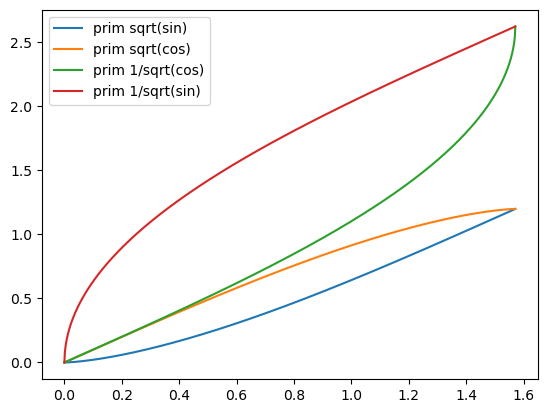

In [30]:
# Test antiderivatives

x = np.linspace(0, np.pi/2., 1000)

plt.plot(x, integ_sqrt_sin(x), label='prim sqrt(sin)')
plt.plot(x, integ_sqrt_cos(x), label='prim sqrt(cos)')
plt.plot(x, integ_inv_sqrt_cos(x), label='prim 1/sqrt(cos)')
plt.plot(x, integ_inv_sqrt_sin(x), label='prim 1/sqrt(sin)')
plt.legend()

plt.show()

(3, 3, 100, 100)


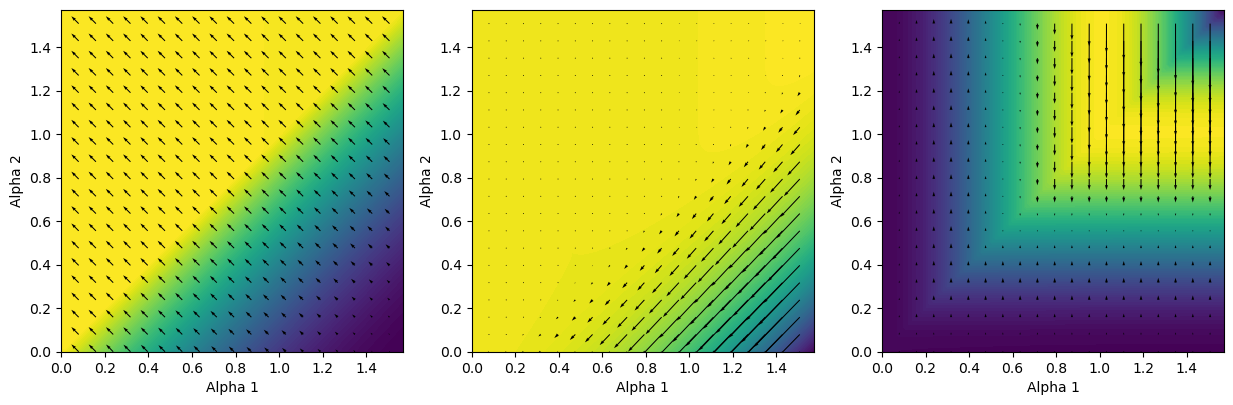

In [137]:
# Plot function to find zero

W, H, a = 1e-1, 5e-2, 2e-2

alpha1_ = np.linspace(0, np.pi/2., 100)
alpha2_ = np.linspace(0, np.pi/2., 100)
force_ = 2.

alpha1, alpha2 = np.meshgrid(alpha1_, alpha2_)
force = np.full_like(alpha1, force_)

eq1, eq2, eq3 = func_all(alpha1, alpha2, force, W, H, a)
jac = jac_all(alpha1, alpha2, force, W, H, a)

print(jac.shape)

# Parameters plot
levels=100

fig, ax = plt.subplots(figsize=(15,5), ncols=3)

ax[0].contourf(alpha1, alpha2, eq1, levels=levels)
ax[1].contourf(alpha1, alpha2, eq2, levels=levels)
ax[2].contourf(alpha1, alpha2, eq3, levels=levels)

alpha1_quiv = alpha1[::5,::5]
alpha2_quiv = alpha2[::5,::5]
jac_quiv = jac[:,:,::5,::5]

ax[0].quiver(alpha1_quiv, alpha2_quiv, jac_quiv[0,0], jac_quiv[0,1], color='k', angles='xy')
ax[1].quiver(alpha1_quiv, alpha2_quiv, jac_quiv[1,0], jac_quiv[1,1], color='k', angles='xy')
ax[2].quiver(alpha1_quiv, alpha2_quiv, jac_quiv[2,0], jac_quiv[2,1], color='k', angles='xy')

for axi in ax:
    axi.set_aspect(1)
    axi.set_xlabel('Alpha 1')
    axi.set_ylabel('Alpha 2')

plt.show()

## Test

In [31]:
W = 10e-2
a = 2e-2
H = 5e-2

func = (lambda guess: func_root_all(guess[0], guess[1], guess[2], W, a, H))

In [32]:
x0 = np.array([np.pi/7., np.pi/10., 2.])

sol = sco.root(func, x0)
sol

    fjac: array([[-0.57735027, -0.57735027, -0.57735027],
       [ 0.76667212, -0.62656515, -0.14010697],
       [ 0.28085676,  0.52352916, -0.80438592]])
     fun: array([-0.00050178, -0.00834056, -0.02065804])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 32
     qtf: array([0.01703205, 0.00773554, 0.01210958])
       r: array([-3.57909726e+17, -3.61545457e+17,  8.74943250e+15,  5.35205849e+00,
       -5.11243901e-02,  2.19620386e-03])
  status: 5
 success: False
       x: array([0.15303857, 0.1449558 , 1.50908076])

In [33]:
sol.x

array([0.15303857, 0.1449558 , 1.50908076])

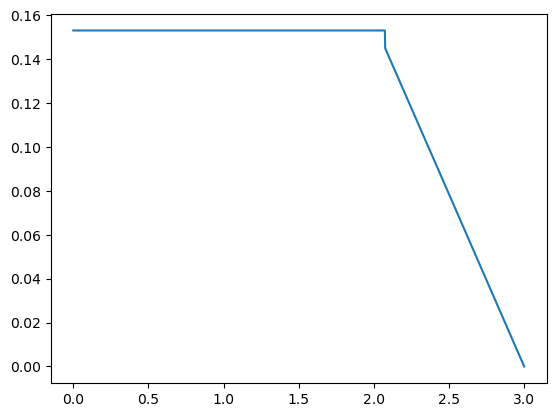

In [60]:
# Plot solution

L = 3
alpha1, alpha2, force = sol.x

s1, s2 = s1_s2_from_param(alpha1, alpha2, force, L)

s, alpha = solve_alpha_from_all_param(s1, s2, L, alpha1, alpha2, force)

fig, ax = plt.subplots()

ax.plot(s, alpha)

plt.show()
